# Kaggle Bengali Handwritten Grapheme Classification

**Acknowledgements:**
1. [Competition](https://www.kaggle.com/c/bengaliai-cv19) on Kaggle.  
2. [Notebook](https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop) by Chris Deotte.  
3. [Video](https://www.youtube.com/watch?v=DEuvGh4ZwaY) on YouTube of the Accelerator Power Hour with Kaggle Grandmasters.  

**References:**
1. [EfficientNet](https://arxiv.org/abs/1905.11946) model.  
2. [Pretrained](https://github.com/lukemelas/EfficientNet-PyTorch) EfficientNet (PyTorch).  
3. [Pretrained](https://pypi.org/project/efficientnet/) EfficientNet (TensorFlow, Keras).  
4. [Parquet](https://parquet.apache.org/) _columnar storage_ format.  
5. [albumentations](https://albumentations.readthedocs.io/en/latest/) for fast image augmentation. ([Github repo](https://github.com/albumentations-team/albumentations))  
6. [CutMix](https://arxiv.org/abs/1905.04899) patch-based regularization strategy for images.  


**Table of contents:**
1. [Imports](#Imports)  
2. [Configure GPUs](#Configure-GPUs)  
3. [Enable mixed precision](#Enable-mixed-precision)  
4. [Set up logging](#Set-up-logging)  
5. [PIPELINE STEP 1: Preprocess](#PIPELINE-STEP-1:-Preprocess)  
   1. [Preprocess - EDA](#Preprocess---EDA)  
6. [PIPELINE STEP 2: Data augmentation](#PIPELINE-STEP-2:-Data-augmentation)  
   1. [Data augmentation - EDA](#Data-augmentation---EDA)  
7. [PIPELINE STEP 3: Build model](#PIPELINE-STEP-3:-Build-model)  
   1. [Validation metric and logging](#Validation-metric-and-logging)  
8. [PIPELINE STEP 4: Training schedule](#PIPELINE-STEP-4:-Training-schedule)  
   1. [Train model](#Train-model)  

## Imports

In [33]:
import time
startNB = time.time()   # Time the execution of the notebook

import tensorflow as tf, os
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score
import albumentations as albu, cv2, gc

print('TensorFlow version = {}'.format(tf.__version__))

TensorFlow version = 2.2.0


## Configure GPUs

In [34]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if len(gpus) == 1: 
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


## Enable mixed precision

In [35]:
# tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')  # When float32 needed, definte dtype explicitly

Mixed precision enabled


## Set up logging

In [36]:
# Logging directory
logging_dir = '../logging/'

# Logging version MAJOR and MINOR
mm = 1
rr = 0

# Begin log file
f = open(os.path.join(logging_dir, f'log-{mm}-{rr}.txt'), 'a')
print('Logging to {}'.format(f.name))

f.write('#############################\n')
f.write(f'Trial mm={mm}, rr={rr}\n')
f.write('efNetB4, batch_size=512, seed=42, 64x64, fold=0, LR 1e-3 with 0.75 decay\n')
f.write('#############################\n')
f.close()

# TODO: Consolidate hyperparameters
BATCH_SIZE = 512
DIM = 64

Logging to ../logging/log-1-0.txt


## PIPELINE STEP 1: Preprocess

Load image data and resize. For optimal GPU speed, do this once before the data loader instead of each time epoch in it. 

_Note: This notebook only uses 25% of the data._

In [37]:
data_dir = '../data/raw/'

In [38]:
%%time
train = []
# for x in [0, 1, 2, 3]:
for x in [0]:  # 25% of data
    f = 'train_image_data_%i.parquet' % x
    print(f, end='')
    img = pd.read_parquet(os.path.join(data_dir, f))  # pd df
    img = img.iloc[:, 1:].values.reshape((-1, 137, 236, 1))  # np array
    img2 = np.zeros((img.shape[0], DIM, DIM, 1), dtype='float32')
    for j in range(img.shape[0]):
        img2[j, :, :, 0] = cv2.resize(img[j,], 
                                      (DIM, DIM),
                                      interpolation=cv2.INTER_AREA)
        if j % 1000 == 0:
            print(j, ', ', end='')
    print()
    img2 = (255 - img2) / 255.  # normalize
    train.append(img2)

train_image_data_0.parquet0 , 1000 , 2000 , 3000 , 4000 , 5000 , 6000 , 7000 , 8000 , 9000 , 10000 , 11000 , 12000 , 13000 , 14000 , 15000 , 16000 , 17000 , 18000 , 19000 , 20000 , 21000 , 22000 , 23000 , 24000 , 25000 , 26000 , 27000 , 28000 , 29000 , 30000 , 31000 , 32000 , 33000 , 34000 , 35000 , 36000 , 37000 , 38000 , 39000 , 40000 , 41000 , 42000 , 43000 , 44000 , 45000 , 46000 , 47000 , 48000 , 49000 , 50000 , 
CPU times: user 37.4 s, sys: 5.16 s, total: 42.5 s
Wall time: 20.6 s


In [39]:
X_train = np.concatenate(train)
print('Train shape', X_train.shape)

Train shape (50210, 64, 64, 1)


In [40]:
del img, img2, train
_ = gc.collect()   # TODO: ?

### Preprocess - EDA

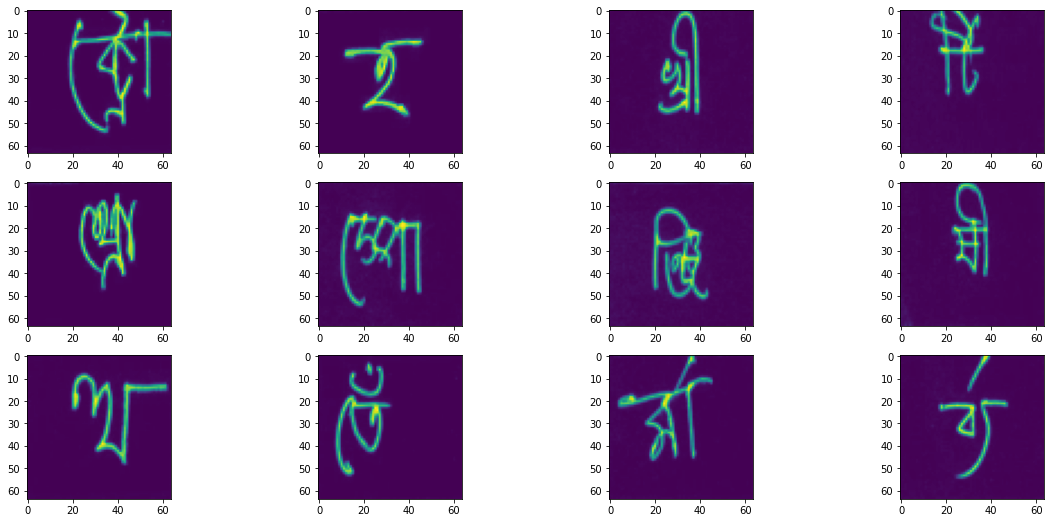

In [41]:
row = 3
col = 4
plt.figure(figsize=(20, (row / col) * 12))
for x in range(row * col):
    plt.subplot(row, col, x + 1)
    plt.imshow(X_train[x, :, :, 0])
plt.show()

In [42]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
y_train = train.iloc[:, 1:4].values[:len(X_train)]  # TODO: grok
print('Labels\nGrapheme Root, Vowel Diacritic, Consonant Diacritic')
y_train

Labels
Grapheme Root, Vowel Diacritic, Consonant Diacritic


array([[ 15,   9,   5],
       [159,   0,   0],
       [ 22,   3,   5],
       ...,
       [ 65,   9,   0],
       [ 24,   0,   0],
       [ 57,   1,   0]])

## PIPELINE STEP 2: Data augmentation

To optimize the data loader for GPU speed:
1. The time to process one batch on the CPU should be **less** the time to train one batch on the GPU.  
2. The batch size should be optimized to **maximize** GPU compute.  

In [43]:
class DataGenerator(tf.keras.utils.Sequence):  # TODO: Sequence
    'Generates data for Keras'
    def __init__(self, X, y, list_IDs, batch_size=BATCH_SIZE,
                 shuffle=False, augment=False, labels=True,
                 cutmix=False, yellow=False):
        self.X = X
        self.y = y
        self.augment = augment
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.labels = labels
        self.cutmix = cutmix
        self.yellow = yellow
        self.on_epoch_end()  # TODO: What does this do?
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.list_IDs) // self.batch_size
        ct += int((len(self.list_IDs) % self.batch_size) != 0)  # One batch if data left
        return ct
    
    def __getitem__(self, index):
        'Generates one batch of data'
        indexes = self.indexes[index * self.batch_size : 
                               (index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment:
            X = self.__augment_batch(X)
        if self.labels:
            return X, [y[:, 0:168], y[:, 168:179], y[:, 179:186]]  # TODO: Examine the data to see labels
        else:
            return X
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)  # TODO: Grok indexes
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X = self.X[self.list_IDs[indexes], ]
        if self.yellow:
            X = np.ones((len(indexes), DIM, DIM, 1))
        y = np.zeros((len(indexes), 186))
        for j in range(len(indexes)):
            y[j,       int(self.y[self.list_IDs[indexes[j]], 0])] = 1  # TODO: Grok
            y[j, 168 + int(self.y[self.list_IDs[indexes[j]], 1])] = 1
            y[j, 179 + int(self.y[self.list_IDs[indexes[j]], 2])] = 1

        if self.cutmix:
            for j in range(len(indexes)):
                
                # Choose random center
                yy = np.random.randint(0, DIM)
                xx = np.random.randint(0, DIM)
                z = np.random.choice(self.list_IDs)  # TODO: Grok
                
                # Choose random width and height
                h = np.random.randint(DIM // 2 - DIM // 16, DIM // 2 + DIM // 16)  # TODO: Grok
                w = np.random.randint(DIM // 2 - DIM // 16, DIM // 2 + DIM // 16)
                
                # Cut and mix images
                ya = max(0, yy - h // 2)
                yb = min(DIM, yy + h // 2)
                xa = max(0, xx - w // 2)
                xb = min(DIM, xx + w // 2)
                X[j, ya:yb, xa:xb, 0] = self.X[z, ya:yb, xa:xb, 0]
                
                # Cut and mix labels
                r = (yb - ya) * (xb - xa) / DIM / DIM   # TODO: Grok
                y2 = np.zeros((1, 186))
                y2[0,       int(self.y[z, 0])] = 1
                y2[0, 168 + int(self.y[z, 1])] = 1
                y2[0, 179 + int(self.y[z, 2])] = 1
                y[j, ] = (1 - r) * y[j, ] + r * y2[0, ]
                
        return X, y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.OneOf([
                albu.ShiftScaleRotate(rotate_limit=8,
                                      scale_limit=0.16,
                                      shift_limit=0,
                                      border_mode=0,
                                      value=0,
                                      p=0.5),
                albu.CoarseDropout(max_holes=16,
                                   max_height=DIM//10,
                                   max_width=DIM//10,
                                   fill_value=0,
                                   p=0.5)
            ], p=0.5),
            albu.ShiftScaleRotate(rotate_limit=0,
                                  scale_limit=0.,
                                  shift_limit=0.12,
                                  border_mode=0,
                                  value=0,
                                  p=0.5)
        ])
        return composition(image=img)['image']  # TODO: Is this a signature?
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

### Data augmentation - EDA

*Cutmix* augmentation mixes two images together:
* The first image is displayed in yellow to visualize the augmentation. *This won't be done during training.*
* Rotation, scaling, shift, and coarse dropout can also be seen.  

Cutmix augmentation with first image in all yellow


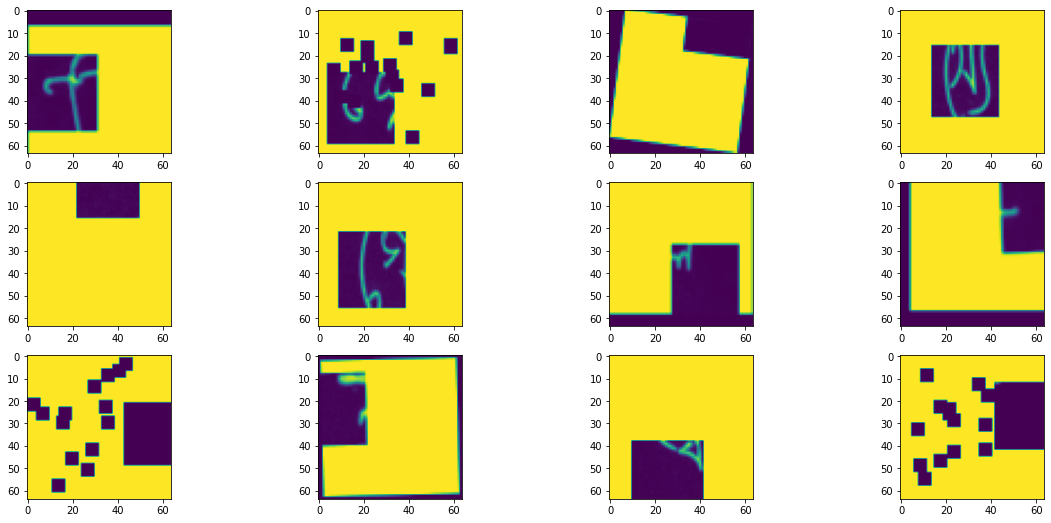

In [44]:
print('Cutmix augmentation with first image in all yellow')
gen = DataGenerator(X_train,
                    y_train,
                    np.arange(len(X_train)),
                    shuffle=True,
                    augment=True,
                    batch_size=BATCH_SIZE,
                    cutmix=True,
                    yellow=True)
row = 3
col = 4
plt.figure(figsize=(20, (row / col) * 12))
for batch in gen:
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.imshow(batch[0][j, :, :, 0])
    plt.show()
    break

## PIPELINE STEP 3: Build model

Use transfer learning from a pretrained ImageNet CNN, in particular, an EfficientNet.

![alt text](../assets/effnet_imagenet.jpeg)

In [45]:
model_dir = '../models/'
weights_file = 'efnB4.h5'

def build_model():
    inp = tf.keras.Input(shape=(DIM, DIM, 1))
    inp2 = tf.keras.layers.Concatenate()([inp, inp, inp])  # 3 channels
    base_model = efn.EfficientNetB4(weights=None,
                                    include_top=False,
                                    input_shape=(DIM, DIM, 3))
    base_model.load_weights(os.path.join(model_dir, weights_file))
    
    x = base_model(inp2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x1 = tf.keras.layers.Dense(168, 
                               activation='softmax',
                               name='x1',
                               dtype='float32')(x)  # Explicit due to mixed precision setup at top
    x2 = tf.keras.layers.Dense(11, 
                               activation='softmax',
                               name='x2',
                               dtype='float32')(x)  # Explicit due to mixed precision setup at top
    x3 = tf.keras.layers.Dense(7, 
                               activation='softmax',
                               name='x3',
                               dtype='float32')(x)  # Explicit due to mixed precision setup at top
    
    model = tf.keras.Model(inputs=inp, outputs=[x1, x2, x3])
    opt = tf.keras.optimizers.Adam(lr=0.00001)
    wgt = {'x1': 1.5, 'x2': 1.0, 'x3': 1.0}   # Due to x2 factor in recall eval for grapheme root
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['categorical_accuracy'],
                  loss_weights=wgt)
    
    return model

### Validation metric and logging

The competition metric is *macro recall*. Recall = tp / p.

In [46]:
from sklearn.metrics import f1_score
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_data, target, fold, mm=0, rr=0, patience=10):
        self.valid_inputs = valid_data
        self.valid_outputs = target
        self.fold = fold
        self.patience = patience
        self.mm = mm
        self.rr = rr
        
    def on_train_begin(self, logs={}):
        self.valid_f1 = [0]  # TODO: Grok
        
    def on_epoch_end(self, epoch, logs={}):
        
        preds = self.model.predict(self.valid_inputs)
        preds0 = np.argmax(preds[0], axis=1)
        preds1 = np.argmax(preds[1], axis=1)
        preds2 = np.argmax(preds[2], axis=1)
        
        r1 = recall_score(self.valid_outputs[0], preds0, average='macro')
        r2 = recall_score(self.valid_outputs[1], preds1, average='macro')
        r3 = recall_score(self.valid_outputs[2], preds2, average='macro')
        
        a1 = accuracy_score(self.valid_outputs[0], preds0)
        a2 = accuracy_score(self.valid_outputs[1], preds1)
        a3 = accuracy_score(self.valid_outputs[2], preds2)
        
        f1 = 0.5 * r1 + 0.25 * r2 + 0.25 * r3
        
        # Log to file
        f = open(os.path.join(logging_dir, 'log-%i-%i.txt' % (self.mm, self.rr)), 'a')
        f.write('#' * 25)
        f.write('\n')
        f.write('#### FOLD %i EPOCH %i\n' % (self.fold + 1, epoch + 1))
        f.write('#### ACCURACY: a1=%.5f, a2=%.5f, a3=%.5f\n' % (a1, a2, a3))
        f.write('#### MACRO RECALL: r1=%.5f, r2=%.5f, r3=%.5f\n' % (r1, r2, r3))
        f.write('#### CV/LB: %.5f\n' % f1)  # TODO: CV?
        
        print('\n')
        print('#' * 25)
        print('#### FOLD %i EPOCH %i' % (self.fold + 1, epoch + 1))
        print('#### ACCURACY: a1=%.5f, a2=%.5f, a3=%.5f' % (a1, a2, a3))
        print('#### MACRO RECALL: r1=%.5f, r2=%.5f, r3=%.5f' % (r1, r2, r3))
        print('#### CV/LB: %.5f' % f1)
        print('#' * 25)
        
        self.valid_f1.append(f1)
        x = np.asarray(self.valid_f1)
        if np.argsort(-x)[0] == (len(x) - self.patience - 1):  # TODO: grok
            print('#### CV/LB no increase for %i epochs: EARLY STOPPING' % self.patience)
            f.write('#### CV/LB no increase for %i epochs: EARLY STOPPING\n' % self.patience)
            self.model.stop_training = True
            
        if (f1 > 0.000) & (f1 > np.max(self.valid_f1[:-1])):  # TODO: > 0.000 ?
            print('#### Saving new best...')
            f.write('#### Saving new best...\n')
            self.model.save_weights(os.path.join(model_dir, 'fold%i-m%i-%i.h5' % (self.fold, self.mm, self.rr)))
            
        f.close()

## PIPELINE STEP 4: Training schedule

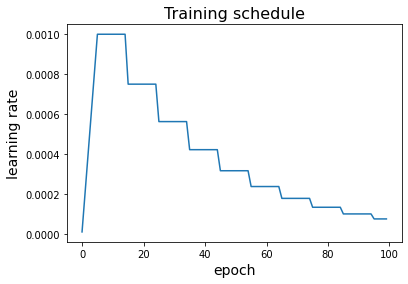

In [47]:
# Custom learning schedule
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY ** ((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // 10)
    
    return lr

lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
plt.xlabel('epoch', size=14)
plt.ylabel('learning rate', size=14)
plt.title('Training schedule', size=16)
plt.show()

### Train model

1. When the validation score doesn't increase for 15 epochs (`patience`), training stops.  
2. This notebook is only trained for 20 epochs.  
3. If training is increased to 150 epochs, the model can score CV/LB 0.98.  
4. Use 100% of the training data.   
5. Larger image size and larger EfficientNet can increase CV/LB to 0.99.  

In [48]:
# Train model

oof1 = np.zeros((X_train.shape[0], 168))
oof2 = np.zeros((X_train.shape[0], 11))
oof3 = np.zeros((X_train.shape[0], 7))

skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)

for fold, (idxT, idxV) in enumerate(skf.split(X_train, y_train[:, 0])):
    
    print('#' * 25)
    print('### FOLD %i' % (fold + 1))
    print('### Training on %i images. Validating on %i images' %
          (len(idxT), len(idxV)))
    print('#' * 25)

    K.clear_session()  # TODO: ?
    with strategy.scope():
        model = build_model()
        
    train_gen = DataGenerator(X_train,
                              y_train,
                              idxT,
                              shuffle=True,
                              augment=True,
                              batch_size=BATCH_SIZE,
                              cutmix=True)
    val_x = DataGenerator(X_train,
                          y_train,
                          idxV,
                          shuffle=False,
                          augment=False,
                          cutmix=False,
                          labels=False,
                          batch_size=BATCH_SIZE * 4)  # TODO: Grok
    val_y = [y_train[idxV, 0], y_train[idxV, 1], y_train[idxV, 2]]
    
    cc = CustomCallback(valid_data=val_x,
                        target=val_y,
                        fold=fold,
                        mm=mm,
                        rr=rr,
                        patience=15)
    h = model.fit(train_gen,
                  epochs=20,
                  verbose=1,
                  callbacks=[cc, lr2])
    
    print('#### Loading best weights...')
    model.load_weights(os.path.join(model_dir, 'fold%i-m%i-%i.h5' % (fold, mm, rr)))
    
    val_x = DataGenerator(X_train,
                          y_train,
                          idxV,
                          shuffle=False,
                          augment=False,
                          cutmix=False,
                          labels=False,
                          batch_size=BATCH_SIZE * 4)
    
    oo = model.predict(val_x)
    oof1[idxV, ] = oo[0]
    oof2[idxV, ] = oo[1]
    oof3[idxV, ] = oo[2]
    
    # Save OOF and IDXV   (TODO: ?)
    np.save('oof1-%i-%i' % (mm, rr), oof1)
    np.save('oof2-%i-%i' % (mm, rr), oof2)
    np.save('oof3-%i-%i' % (mm, rr), oof3)
    np.save('idxV-%i-%i' % (mm, rr), idxV)
    np.save('y_train-%i-%i' % (mm, rr), y_train)
    break
    

#########################
### FOLD 1
### Training on 40168 images. Validating on 10042 images
#########################

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 422 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 422 all-reduces with algorithm = nccl, num_packs = 1
79/79 [==============================] - ETA: 0s - x3_loss: 2.0286 - x3_categorical_accuracy: 0.1663 - x2_categorical_accuracy: 0.0976 - x1_loss: 5.2661 - x2_loss: 2.5174 - loss: 12.4452 - x1_categorical_accuracy: 0.0061

#########################
#### FOLD 1 EPOCH 1
#### ACCURACY: a1=0.00279, a2=0.08504, a3=0.07767
#### MACRO RECALL: r1=0.00606, r2=0.08407, r3=0.12991
#### CV/LB: 0.05652
#########################
#### Saving new best...
79/79 [==============================] - 34s 432ms/step - x3_loss: 2.0286 - x3_categorical_accuracy: 0.1663 - x2_categorical_accuracy: 0.0976 - x1_loss: 5.2661 - x2_loss: 2.5174 - loss

79/79 [==============================] - ETA: 0s - x3_loss: 0.7325 - x3_categorical_accuracy: 0.8082 - x2_categorical_accuracy: 0.7117 - x1_loss: 2.8245 - x2_loss: 1.2025 - loss: 6.1718 - x1_categorical_accuracy: 0.4737

#########################
#### FOLD 1 EPOCH 11
#### ACCURACY: a1=0.78610, a2=0.93189, a3=0.93916
#### MACRO RECALL: r1=0.74803, r2=0.89317, r3=0.85848
#### CV/LB: 0.81193
#########################
#### Saving new best...
79/79 [==============================] - 20s 259ms/step - x3_loss: 0.7325 - x3_categorical_accuracy: 0.8082 - x2_categorical_accuracy: 0.7117 - x1_loss: 2.8245 - x2_loss: 1.2025 - loss: 6.1718 - x1_categorical_accuracy: 0.4737 - lr: 0.0010

Epoch 00012: LearningRateScheduler reducing learning rate to 0.001.
Epoch 12/20
79/79 [==============================] - ETA: 0s - x3_loss: 0.7219 - x3_categorical_accuracy: 0.8154 - x2_categorical_accuracy: 0.7246 - x1_loss: 2.7666 - x2_loss: 1.1836 - loss: 6.0554 - x1_categorical_accuracy: 0.4886

################

## PIPELINE STEP 5: Postprocess

Competition metric is macro recall. The training loss did not optimize this so it needs to be done after training.

In [49]:
oo = model.predict(val_x, verbose=1)  # TODO: What are these?
oof1[idxV, ] = oo[0]
oof2[idxV, ] = oo[1]
oof3[idxV, ] = oo[2]

5/5 [==============================] - 0s 78ms/step


In [50]:
# TODO: Grok all this
oof1b = np.argmax(oof1[idxV, ], axis=1)
oof2b = np.argmax(oof2[idxV, ], axis=1)
oof3b = np.argmax(oof3[idxV, ], axis=1)

r1 = recall_score(y_train[idxV, 0], oof1b, average='macro')
r2 = recall_score(y_train[idxV, 1], oof2b, average='macro')
r3 = recall_score(y_train[idxV, 2], oof3b, average='macro')

r = 0.5 * r1 + 0.25 * r2 + 0.25 * r3

print('CV/LB without postprocessing is %.5f' % r)

CV/LB without postprocessing is 0.88509


In [51]:
# TODO: Grok this
EXP = -0.9

s = pd.Series(oof1b)
vc = s.value_counts().sort_index()
mat1 = np.diag(vc.astype('float32') ** (EXP))

s = pd.Series(oof2b)
vc = s.value_counts().sort_index()
mat2 = np.diag(vc.astype('float32') ** (EXP))

s = pd.Series(oof3b)
vc = s.value_counts().sort_index()
mat3 = np.diag(vc.astype('float32') ** (EXP))

In [52]:
oof1b = np.argmax(oof1[idxV, ].dot(mat1), axis=1)
oof2b = np.argmax(oof2[idxV, ].dot(mat2), axis=1)
oof3b = np.argmax(oof3[idxV, ].dot(mat3), axis=1)

r1 = recall_score(y_train[idxV, 0], oof1b, average='macro')
r2 = recall_score(y_train[idxV, 1], oof2b, average='macro')
r3 = recall_score(y_train[idxV, 2], oof3b, average='macro')

r = 0.5 * r1 + 0.25 * r2 + 0.25 * r3

print('CV/LB after postprocessing is %.5f' % r)

CV/LB after postprocessing is 0.91129


## Predict test and submit to Kaggle

Experiment many times!

### Preprocess test

In [53]:
def getTest(x):
    f = 'test_image_data_%i.parquet' % x
    img = pd.read_parquet(os.path.join(data_dir, f)) # pd df
    img = img.iloc[:, 1:].values.reshape((-1, 137, 236, 1)) # np array
    img2 = np.zeros((img.shape[0], DIM, DIM, 1), dtype='float32')
    for j in range(img.shape[0]):
        img2[j, :, :, 0] = cv2.resize(img[j, ], (DIM, DIM), interpolation=cv2.INTER_AREA)
    return (255 - img2) / 255

### Predict and postprocess test

In [54]:
EXP = -0.9
# del X_train
# gc.collect()

# Load best model
model.load_weights(os.path.join(model_dir, 'fold%i-m%i-%i.h5' % (fold, mm, rr)))

# Predict test
preds1 = []
preds2 = []
preds3 = []
for x in [0, 1, 2, 3]:
    preds = model.predict(getTest(x), verbose=1)
    preds1.append(preds[0])
    preds2.append(preds[1])
    preds3.append(preds[2])
    
pred1 = np.argmax(np.vstack(preds1), axis=1)
pred2 = np.argmax(np.vstack(preds2), axis=1)
pred3 = np.argmax(np.vstack(preds3), axis=1)

# Postprocess
s = pd.Series(pred1)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a': np.arange(168), 'b': np.ones(168)})
df.b = df.a.map(vc)
df.fillna(df.b.min(), inplace=True)
mat1 = np.diag(df.b.astype('float32') ** (EXP))

s = pd.Series(pred2)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a': np.arange(11), 'b': np.ones(11)})
df.b = df.a.map(vc)
df.fillna(df.b.min(), inplace=True)
mat2 = np.diag(df.b.astype('float32') ** (EXP))

s = pd.Series(pred3)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a': np.arange(7), 'b': np.ones(7)})
df.b = df.a.map(vc)
df.fillna(df.b.min(), inplace=True)
mat3 = np.diag(df.b.astype('float32') ** (EXP))

# Apply preprocessing
pred1 = np.argmax(np.vstack(preds1).dot(mat1), axis=1)
pred2 = np.argmax(np.vstack(preds2).dot(mat2), axis=1)
pred3 = np.argmax(np.vstack(preds3).dot(mat3), axis=1)

1/1 [==============================] - 0s 1ms/step


In [55]:
submission_dir = '../submission'
row_id = []
target = []
for i in range(len(pred1)):
    row_id += [f'Test_{i}_grapheme_root',
               f'Test_{i}_vowel_diacritic',
               f'Test_{i}_consonant_diacritic']
    target += [pred1[i], pred2[i], pred3[i]]
sub = pd.DataFrame({'row_id': row_id, 'target': target})
sub.to_csv('submission.csv', index=False)
sub.head()

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,1
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2


In [60]:
print('Notebook elapsed time = %.1f minutes' % ((time.time() - startNB) / 60))

Notebook elapsed time = 23.2 minutes


In [61]:
del X_train
gc.collect()

2219